In [1]:
import time
import numpy as np
from keras import models
from keras import layers
from keras import backend as K
#from segnet_model import build_segnet_basic
from PIL import Image
from keras import utils
from keras import optimizers
from keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
%matplotlib inline
import json
from glob import glob
import os
import src.segtools as segtools
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


# First need to acquire the data from skynet-data repo that has our linked road and image data

In [6]:
# if we want to transfer the downloaded data from skynet to local data directory
#segtools.move_data('/data/train.txt', '/contents/images/train')
#segtools.move_data('/data/val.txt', '/contents/images/val')

In [2]:
#get the data

x_train, y_train = segtools.get_xy_data('/contents/images/train')
#print(x_train.shape, x_val.shape)
#print(y_train.shape, y_val.shape)
#get the number of classes
classes = np.unique(y_train)
num_classes = len(classes)
#x_train, y_train = segtools.data_generator(x_train, y_train) 
#TODO: use the keras package to generate data on the fly as batches to feed into model
#too much data to load into memory at the moment
# turn the raw data into usable data
x_train = segtools.pre_process_x(x_train)
#print(x_train.shape, x_val.shape)


In [3]:
print(x_train.shape)
print(y_train.shape)

(7246, 256, 256, 3)
(7246, 256, 256, 3)


In [4]:
y_train = segtools.pre_process_y(y_train, num_classes)
class_weights = segtools.get_weights(y_train)
print(class_weights)
#print(y_train.shape, y_val.shape)
print(np.max(y_train))

[ 19.10052513   0.51344048]
1


# Try a new model architecture..

In [5]:
input_shape = x_train.shape[1:]
output_shape = y_train.shape[1:]


In [6]:
K.clear_session() #make sure previous sessions are cleared.
# build the layers since we don't have a Sequential model

input_layer = layers.Input(shape=input_shape) 
# first convolution
# first block of first layer
x = layers.Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same')(input_layer)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x) # we will reuse this one on deconvolution
x = layers.Dropout(0.4)(x)
x = layers.Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same')(x)
x = layers.BatchNormalization()(x)
# add input layer...
shortcut = layers.Conv2D(32, kernel_size=(1,1), strides=(1,1), padding='valid')(input_layer)
x = layers.Add()([shortcut,x])
x = layers.LeakyReLU()(x) # we will reuse this one on deconvolution
x1 = layers.Dropout(0.4)(x)

x_ = layers.MaxPooling2D(pool_size=(2,2))(x1)
x = layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same')(x_)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x) # second residual layer 
x = layers.Dropout(0.4)(x)
x = layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same')(x)
x = layers.BatchNormalization()(x)
shortcut = layers.Conv2D(64, kernel_size=(1,1), strides=(1,1), padding='valid')(x_)
x = layers.Add()([shortcut, x])
x = layers.LeakyReLU()(x) # second residual layer 
x2 = layers.Dropout(0.4)(x)

x_ = layers.MaxPooling2D(pool_size=(2,2))(x2)
x = layers.Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same')(x_)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x) # third residual layer 
x = layers.Dropout(0.4)(x)
x = layers.Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same')(x)
x = layers.BatchNormalization()(x)
shortcut = layers.Conv2D(128, kernel_size=(1,1), strides=(1,1), padding='valid')(x_)
x = layers.Add()([shortcut, x])
x = layers.LeakyReLU()(x) # third residual layer 
x3 = layers.Dropout(0.4)(x)

x_ = layers.MaxPooling2D(pool_size=(2,2))(x3)
x = layers.Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same')(x_)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x) # final residual layer on convolution
x = layers.Dropout(0.4)(x)
x = layers.Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same')(x)
x = layers.BatchNormalization()(x)
shortcut = layers.Conv2D(256, kernel_size=(1,1), strides=(1,1), padding='valid')(x_)
x = layers.Add()([shortcut, x])
x = layers.LeakyReLU()(x) # final residual layer on convolution
deep_x = layers.Dropout(0.4)(x)

# deepest layer
x = layers.Conv2D(512, kernel_size=(3,3), strides=(1,1), padding='same')(deep_x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x) # final residual layer on convolution
x = layers.Dropout(0.4)(x)

x = layers.Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x) # final residual layer on convolution
x = layers.Dropout(0.4)(x)
x = layers.Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same')(x)
x = layers.BatchNormalization()(x)
shortcut = layers.Conv2D(256, kernel_size=(1,1), strides=(1,1), padding='valid')(deep_x)
x = layers.Add()([shortcut, x])
x = layers.LeakyReLU()(x) # final residual layer on convolution
_deep_x = layers.Dropout(0.4)(x)

# deconvolve

x_ = layers.UpSampling2D(size=(2,2))(_deep_x)
#now concatenate the upsample with the residual layer for convolution
x = layers.concatenate([x_, x3])
x = layers.Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x) # first deconvolve layer
x = layers.Dropout(0.4)(x)
x = layers.Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same')(x)
x = layers.BatchNormalization()(x)
shortcut = layers.Conv2D(128, kernel_size=(1,1), strides=(1,1), padding='valid')(x_)
x = layers.Add()([shortcut, x])
x = layers.LeakyReLU()(x) # first deconvolve layer
_x3 = layers.Dropout(0.4)(x)

x_ = layers.UpSampling2D(size=(2,2))(_x3)
#now concatenate the upsample with the residual layer for convolution
x = layers.concatenate([x_, x2])
x = layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x) # first deconvolve layer
x = layers.Dropout(0.4)(x)
x = layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same')(x)
x = layers.BatchNormalization()(x)
shortcut = layers.Conv2D(64, kernel_size=(1,1), strides=(1,1), padding='valid')(x_)
x = layers.Add()([shortcut, x])
x = layers.LeakyReLU()(x) # first deconvolve layer
_x2 = layers.Dropout(0.4)(x)

x_ = layers.UpSampling2D(size=(2,2))(_x2)
#now concatenate the upsample with the residual layer for convolution
x = layers.concatenate([x_, x1])
x = layers.Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x) # first deconvolve layer
x = layers.Dropout(0.4)(x)
x = layers.Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same')(x)
x = layers.BatchNormalization()(x)
shortcut = layers.Conv2D(32, kernel_size=(1,1), strides=(1,1), padding='valid')(x_)
x = layers.Add()([shortcut, x])
x = layers.LeakyReLU()(x) # first deconvolve layer
_x1 = layers.Dropout(0.4)(x)

x = layers.Conv2D(2, kernel_size=(3,3), strides=(1,1), padding='same')(_x1)
x = layers.Reshape(target_shape=output_shape)(x)
output_layer = layers.Activation('softmax')(x)
#done!

tensorboard = TensorBoard(log_dir='/contents/logs/', histogram_freq=0, write_graph=True, write_images=False)
model = models.Model(inputs=[input_layer] ,outputs=[output_layer])
opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['categorical_accuracy'])

In [9]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 256, 256, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
dropout_1 

In [12]:
num_classes = 2
model.fit(x_train, y_train, \
                 batch_size=7, epochs=25, class_weight=class_weights,\
                 shuffle=True, verbose=True, callbacks=[tensorboard])

Epoch 1/25
7246/7246 [==============================] - 589s 81ms/step - loss: 0.0886 - categorical_accuracy: 0.9741
Epoch 2/25
7246/7246 [==============================] - 598s 83ms/step - loss: 0.0638 - categorical_accuracy: 0.9761
Epoch 3/25
7246/7246 [==============================] - 606s 84ms/step - loss: 0.0602 - categorical_accuracy: 0.9772
Epoch 4/25
7246/7246 [==============================] - 598s 82ms/step - loss: 0.0575 - categorical_accuracy: 0.9780
Epoch 5/25
7246/7246 [==============================] - 598s 83ms/step - loss: 0.0565 - categorical_accuracy: 0.9782
Epoch 6/25
7246/7246 [==============================] - 604s 83ms/step - loss: 0.0554 - categorical_accuracy: 0.9787
Epoch 7/25
7246/7246 [==============================] - 605s 83ms/step - loss: 0.0545 - categorical_accuracy: 0.9790
Epoch 8/25
7246/7246 [==============================] - 614s 85ms/step - loss: 0.0541 - categorical_accuracy: 0.9790
Epoch 9/25
7246/7246 [==============================] - 606s 84m

In [13]:
t = time.strftime('%Y%m%d%H%M', time.gmtime())
os.makedirs('./fit_models/%s'%t)
model.save_weights('./fit_models/%s/seg_net.h5'%t)
# serialize model to JSON

with open('./fit_models/%s/seg_net.json'%t, 'w') as outfile:
    outfile.write(json.dumps(json.loads(model.to_json()), indent=2))

In [24]:
x_val, y_val = segtools.get_xy_data('/contents/images/val')
x_val = segtools.pre_process_x(x_val)
y_val = segtools.pre_process_y(y_val, num_classes)

In [26]:
pr = model.predict(x_val)
predictions = []
for i in range(len(pr)):
    predictions.append(pr[i].reshape((256,256,num_classes)))
predictions = np.array(predictions)
norm_pred = segtools.normalize_stack(predictions[:,:,:,0])

In [86]:
pr.shape

(4078, 65536, 2)

0.0268809614989


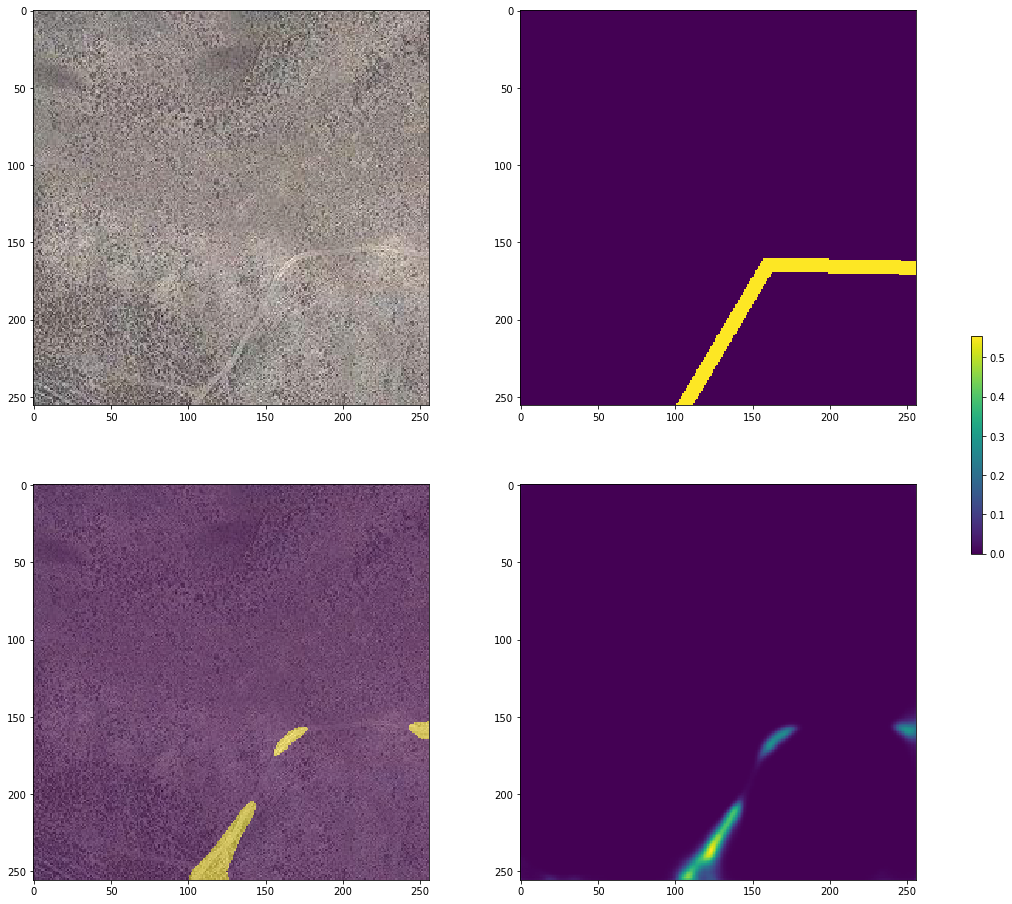

In [157]:
thr=class_weights[1]/class_weights[0]
print(thr)
thr=0.1
f, ax = plt.subplots(2,2, figsize=(20, 16))
sample=np.random.randint(0, len(x_val))
x_ = x_val[sample].astype('float32')
y_ = y_val[sample].reshape(256,256,num_classes)[:,:,0]
ax[0,0].imshow(x_)
ax[0,1].imshow(y_)
ax[1,0].imshow(x_)
mask = np.zeros((256,256))
mask[norm_pred[sample]>=thr] = 1
ax[1,0].imshow(mask,alpha=0.5)
#mask = np.argmax(pr[sample].reshape(256,256,num_classes), axis=2)
#ax[1,0].imshow(~mask,alpha=0.5)

im = ax[1,1].imshow(norm_pred[sample])
f.colorbar(im, ax=ax.ravel().tolist(), shrink=0.25)

(4078, 65536, 2)


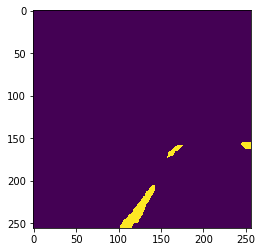

In [158]:
print(np.shape(pr))
classified = np.zeros((pr.shape[0], pr.shape[1],1))
thr = 0.15
classified[pr[:,:,0]>=thr]=1
plt.imshow(classified[sample,:,:].reshape((256,256)))

In [159]:
tr = []
tpr = []
a = []
cc = []
classified = np.zeros((pr.shape[0], pr.shape[1],1))
thr = 0.15
classified[pr[:,:,0]>=thr]=1
r = y_val[:,:,0].astype('bool')
p_r = classified[:,:,0].astype('bool')
for i in range(len(pr)):
    tr.append(np.sum(r[i]))
    tpr.append(np.sum(p_r[i]))
    a.append(np.sum(np.logical_and(r[i], p_r[i])))
tr = np.array(tr)
tpr = np.array(tpr)
a = np.array(a)
completeness = np.nanmean(np.divide(a,tr))
correctness = np.nanmean(np.divide(a,tpr))
cc.append([completeness, correctness])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


IndexError: invalid index to scalar variable.

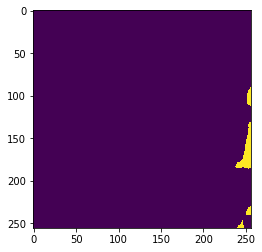

In [160]:
sample = 20
plt.imshow(p_r[sample].reshape(256,256))
print(completeness[sample])

In [161]:
np.nanmean(completeness)

0.32842770780598957

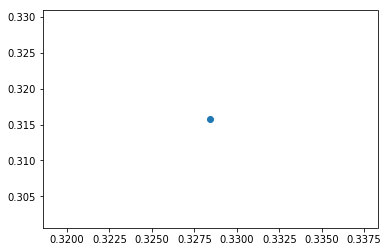

In [162]:
plt.scatter(completeness, correctness)

In [163]:
plt.imshow(np.reshape(classes[0], (256,256)))

ValueError: cannot reshape array of size 1 into shape (256,256)

In [164]:
# construct a confusion matrix using various masks...
t_min = 0
t_max = 0.2
n_thr = 2
c = pr[:,:,0]
c.reshape((c.shape[0]*c.shape[1]))
def generate_threshold_masks(c, n_thr, t_min, t_max):
    input_shape = np.shape(c)
    masks = np.zeros((n_thr, np.shape(c))).astype('bool')
    thr = np.linspace(t_min, t_max, n_thr) 
    for i in range(len(t)):
        masks[i][c>=thr[i]] = True 
    return(masks)
masks = generate_threshold_masks(c, n_thr, t_min, t_max)

TypeError: 'tuple' object cannot be interpreted as an integer

In [144]:
target = y_val[:,:,0].astype('bool')
n_cells = np.shape(target)[0] * np.shape(target)[1]

#overall accuracy.
sensitivity = np.zeros(len(masks)) 
specificity = np.zeros(len(masks)) 
for i in range(len(masks)):
    print(np.sum((target & masks[i]))/n_cells)
    print(np.sum((~target & ~masks[i]))/n_cells)

NameError: name 'masks' is not defined

# Try predicting on the entire Tonopah dataset

## See 'predictions.ipynb'